# 特征优化和特征选择

出发点：

- 模型简化
- 训练时间
- 通用性和过拟合

特点：

1. 不创造新数据
2. 删去多余数据
3. 常用于文本、微阵列数据

![p1.png](<attachment:p1.png>)
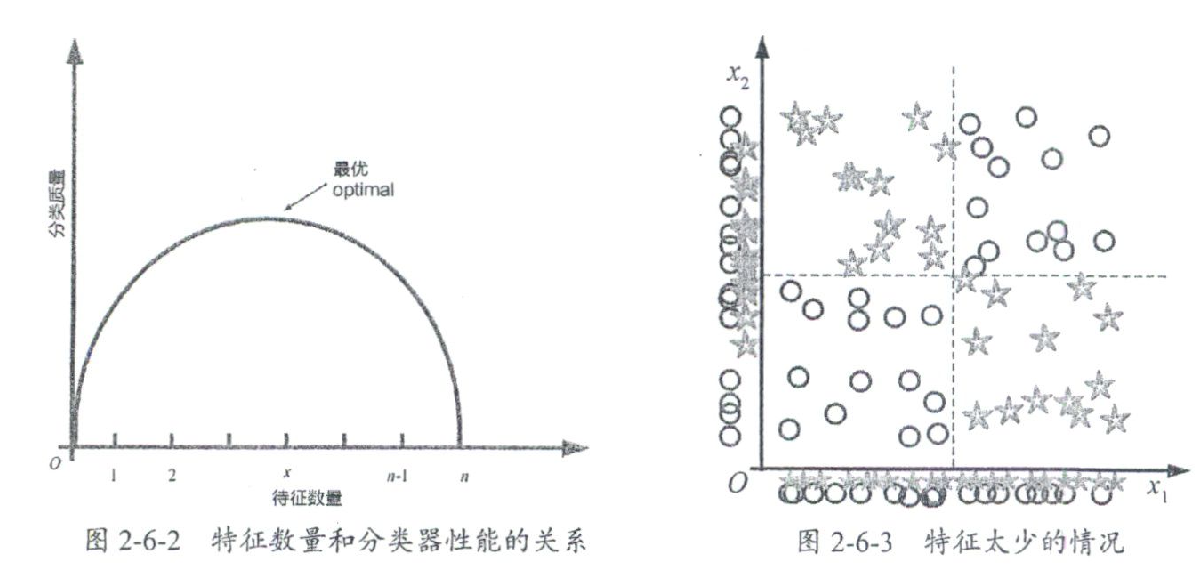

![p2.png](<attachment:p2.png>)
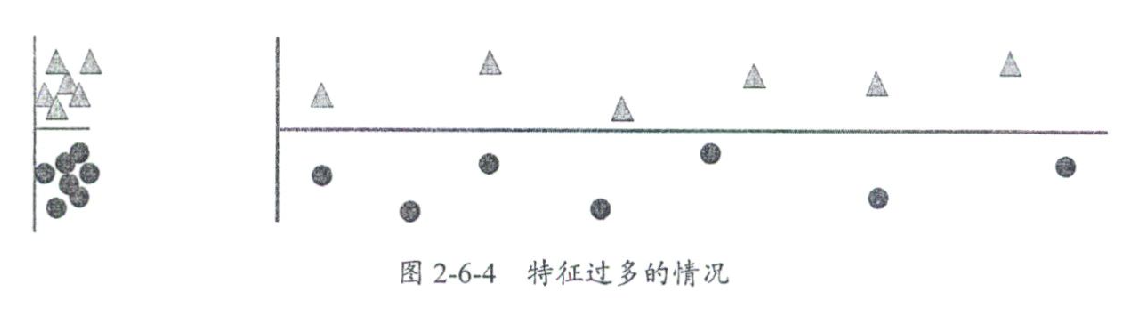

## 导入相关包

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore") 

## 读取数据（训练数据前10000行，测试数据前100条）

In [2]:
train_data = pd.read_csv('train_all.csv',nrows=10000)
test_data = pd.read_csv('test_all.csv',nrows=100)

## 读取全部数据

In [3]:
# train_data = pd.read_csv('train_all.csv',nrows=None)
# test_data = pd.read_csv('test_all.csv',nrows=None)

## 获取训练和测试数据

In [4]:
features_columns = [col for col in train_data.columns if col not in ['user_id','label']]
train = train_data[features_columns].values
test = test_data[features_columns].values
target =train_data['label'].values

## 缺失值补全

处理缺失值有很多方法，最常用为以下几种：
1. 删除。当数据量较大时，或者缺失数据占比较小时，可以使用这种方法。
2. 填充。通用的方法是采用平均数、中位数来填充，可以适用插值或者模型预测的方法进行缺失补全。
3. 不处理。树类模型对缺失值不明感。

#### 采用中值进行填充

In [5]:
# from sklearn.preprocessing import Imputer
# imputer = Imputer(strategy="median")

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(train)
train_imputer = imputer.transform(train)
test_imputer = imputer.transform(test)

## 特征选择概念

要使用特征选择技术的关键假设是：训练数据包含许多冗余 或无关 的特征，因而移除这些特征并不会导致丢失信息。

冗余或无关特征是两个不同的概念。如果一个特征本身有用，但如果这个特征与另一个有用特征强相关，且那个特征也出现在数据中，那么这个特征可能就变得多余。

特征选择技术与特征提取有所不同。特征提取是从原有特征的功能中创造新的特征，而特征选择则只返回原有特征中的子集。

特征选择技术的常常用于许多特征但样本（即数据点）相对较少的领域。特征选择应用的典型用例包括：解析书面文本和微阵列数据，这些场景下特征成千上万，但样本只有几十到几百个。

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

def feature_selection(train, train_sel, target):
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
    
    scores = cross_val_score(clf, train, target, cv=5)
    scores_sel = cross_val_score(clf, train_sel, target, cv=5)
    
    print("No Select Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))     
    print("Features Select Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### 删除方差较小的要素（方法一）
VarianceThreshold是一种简单的基线特征选择方法。它会删除方差不符合某个阈值的所有要素。默认情况下，它会删除所有零方差要素，即在所有样本中具有相同值的要素。

In [7]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel = sel.fit(train)
train_sel = sel.transform(train)
test_sel = sel.transform(test)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

训练数据未特征筛选维度 (2000, 229)
训练数据特征筛选维度后 (2000, 25)


### 特征选择前后区别

In [8]:
feature_selection(train, train_sel, target)

No Select Accuracy: 0.93 (+/- 0.00)
Features Select Accuracy: 0.93 (+/- 0.00)


### 单变量特征选择（方法二）
通过基于单变量统计检验选择最佳特征。

In [9]:
from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

sel = SelectKBest(mutual_info_classif, k=2)
sel = sel.fit(train, target)
train_sel = sel.transform(train)
test_sel = sel.transform(test)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

训练数据未特征筛选维度 (2000, 229)
训练数据特征筛选维度后 (2000, 2)


In [10]:
sel = SelectKBest(mutual_info_classif, k=10)
sel = sel.fit(train, target)
train_sel = sel.transform(train)
test_sel = sel.transform(test)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

训练数据未特征筛选维度 (2000, 229)
训练数据特征筛选维度后 (2000, 10)


### 特征选择前后区别

In [11]:
feature_selection(train, train_sel, target)

No Select Accuracy: 0.93 (+/- 0.00)
Features Select Accuracy: 0.93 (+/- 0.00)


### 递归功能消除（方法三）
选定模型拟合，进行递归拟合，每次把评分低得特征去除，重复上诉循环。

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0, n_jobs=-1)
selector = RFECV(clf, step=1, cv=2)
selector = selector.fit(train, target)
print(selector.support_)
print(selector.ranking_)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False  True False  True  True  True  True False  True False False  True
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

### 使用模型选择特征（方法四）

#### 使用LR拟合的参数进行变量选择（L2范数进行特征选择）
LR模型采用拟合参数形式进行变量选择，筛选对回归目标影响大的

In [13]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer = normalizer.fit(train)

train_norm = normalizer.transform(train)
test_norm = normalizer.transform(test)

LR = LogisticRegression(penalty="l2", C=5)
LR = LR.fit(train_norm, target)
model = SelectFromModel(LR, prefit=True)
train_sel = model.transform(train)
test_sel = model.transform(test)
print("训练数据未特征筛选维度", train.shape)
print("训练数据特征筛选维度后", train_sel.shape)

训练数据未特征筛选维度 (2000, 229)
训练数据特征筛选维度后 (2000, 19)


##### L2范数选择参数

In [14]:
LR.coef_[0][:10]

array([ 0.33811199, -0.01853089, -0.00336732,  0.93955438, -0.25635882,
       -0.14295861, -0.24057402,  0.32556829,  0.08031139, -0.01785117])

### 特征选择前后区别

In [15]:
feature_selection(train, train_sel, target)

No Select Accuracy: 0.93 (+/- 0.00)
Features Select Accuracy: 0.93 (+/- 0.00)


#### 使用LR拟合的参数进行变量选择（L1范数进行特征选择）
LR模型采用拟合参数形式进行变量选择，筛选对回归目标影响大的

In [16]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import Normalizer

# normalizer = Normalizer()
# normalizer = normalizer.fit(train)  

# train_norm = normalizer.transform(train)                            
# test_norm = normalizer.transform(test)

# LR = LogisticRegression(penalty='l1',C=5)
# LR = LR.fit(train_norm, target)
# model = SelectFromModel(LR, prefit=True)
# train_sel = model.transform(train)
# test_sel = model.transform(test)
# print('训练数据未特征筛选维度', train.shape)
# print('训练数据特征筛选维度后', train_sel.shape)

##### L1范数选择参数
对于α的良好选择，只要满足某些特定条件，Lasso就可以仅使用少量观察来完全恢复精确的非零变量集。

In [17]:
# LR.coef_[0][:10]

### 特征选择前后区别

In [18]:
feature_selection(train, train_sel, target)

No Select Accuracy: 0.93 (+/- 0.00)
Features Select Accuracy: 0.93 (+/- 0.00)


### 基于树模型特征选择
树模型基于分裂评价标准所计算的总的评分作为依据进行相关排序，然后进行特征筛选

In [19]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(train, target)

model = SelectFromModel(clf, prefit=True)
train_sel = model.transform(train)
test_sel = model.transform(test)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

训练数据未特征筛选维度 (2000, 229)
训练数据特征筛选维度后 (2000, 64)


#### 树特征重要性

In [20]:
clf.feature_importances_[:10]

array([0.0799965 , 0.01636938, 0.00929514, 0.01709713, 0.01657728,
       0.0141105 , 0.01497807, 0.01682269, 0.01762355, 0.00673445])

In [21]:
df_features_import = pd.DataFrame()
df_features_import['features_import'] = clf.feature_importances_
df_features_import['features_name'] = features_columns

In [22]:
df_features_import.sort_values(['features_import'],ascending=0).head(30)

,features_import,features_name
228,0.081641,xgb_clf
0,0.079997,merchant_id
227,0.071232,lgb_clf
20,0.019990,brand_most_1_cnt
15,0.019173,cat_most_1
12,0.019066,time_stamp_std
18,0.018673,seller_most_1_cnt
25,0.017933,user_cnt_3
8,0.017624,time_stamp_nunique
14,0.017127,seller_most_1


In [23]:
# features_columns

### 特征选择前后区别

In [24]:
feature_selection(train, train_sel, target)

No Select Accuracy: 0.93 (+/- 0.00)
Features Select Accuracy: 0.93 (+/- 0.00)


### Lgb特征重要性

In [25]:
import lightgbm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train, target, test_size=0.4, random_state=0
)

clf = lightgbm

train_matrix = clf.Dataset(X_train, label=y_train)
test_matrix = clf.Dataset(X_test, label=y_test)
params = {
    "boosting_type": "gbdt",
    #'boosting_type': 'dart',
    "objective": "multiclass",
    "metric": "multi_logloss",
    "min_child_weight": 1.5,
    "num_leaves": 2**5,
    "lambda_l2": 10,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.7,
    "learning_rate": 0.03,
    "tree_method": "exact",
    "seed": 2017,
    "num_class": 2,
    "silent": True,
}
num_round = 10000
early_stopping_rounds = 100
model = clf.train(
    params,
    train_matrix,
    num_round,
    valid_sets=test_matrix,
    # early_stopping_rounds=early_stopping_rounds,
)

[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6627
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 124
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Info] Start training from score -0.068100
[LightGBM] [Info] Start training from score -2.720629
[LightGBM] [Warning] No further splits with positive gain, best gain

In [26]:
def lgb_transform(train, test, model, topK):
    train_df = pd.DataFrame(train)
    train_df.columns = range(train.shape[1])
    
    test_df = pd.DataFrame(test)
    test_df.columns = range(test.shape[1])
    
    features_import = pd.DataFrame()
    features_import['importance'] = model.feature_importance()
    features_import['col'] = range(train.shape[1])
    
    features_import = features_import.sort_values(['importance'],ascending=0).head(topK)
    sel_col = list(features_import.col)
    
    train_sel = train_df[sel_col]
    test_sel = test_df[sel_col]
    return train_sel, test_sel

In [27]:
train_sel, test_sel = lgb_transform(train, test, model, 20)
print('训练数据未特征筛选维度', train.shape)
print('训练数据特征筛选维度后', train_sel.shape)

训练数据未特征筛选维度 (2000, 229)
训练数据特征筛选维度后 (2000, 20)


### lgb特征重要性

In [28]:
model.feature_importance()[:10]

array([18587,  3504,   663,  3091,  3712,  4826,  3952,  4529,  3856,
         403], dtype=int32)

In [29]:
#sorted(model.feature_importance(),reverse=True)[:10]

### 特征选择前后区别

In [30]:
feature_selection(train, train_sel, target)

No Select Accuracy: 0.93 (+/- 0.00)
Features Select Accuracy: 0.93 (+/- 0.00)


## 总结

- 文章按照数据预处理、数据探索、特征工程、模型训练、模型优化、特征选择等步骤，应用传统机器学习方法进行实战演练。
- 文章亮点包括数据体积压缩、特征工程提取、模型优化等技巧，这在深度学习应用中也值得参考。